In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import multiprocessing
import torchvision
import timm
import os
from transformers import *
from datasets import load_dataset
from PIL import Image
from torchinfo import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
import time

torch.cuda.empty_cache()
device="cuda" if torch.cuda.is_available() else "cpu"

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.0.1+cu117)
    Python  3.9.18 (you have 3.9.17)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


### Loading in data and pretrained model

In [2]:
timm.list_models("vit*",pretrained=True)

['vit_base_patch8_224.augreg2_in21k_ft_in1k',
 'vit_base_patch8_224.augreg_in21k',
 'vit_base_patch8_224.augreg_in21k_ft_in1k',
 'vit_base_patch8_224.dino',
 'vit_base_patch14_dinov2.lvd142m',
 'vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'vit_base_patch16_224.augreg_in1k',
 'vit_base_patch16_224.augreg_in21k',
 'vit_base_patch16_224.augreg_in21k_ft_in1k',
 'vit_base_patch16_224.dino',
 'vit_base_patch16_224.mae',
 'vit_base_patch16_224.orig_in21k_ft_in1k',
 'vit_base_patch16_224.sam_in1k',
 'vit_base_patch16_224_miil.in21k',
 'vit_base_patch16_224_miil.in21k_ft_in1k',
 'vit_base_patch16_384.augreg_in1k',
 'vit_base_patch16_384.augreg_in21k_ft_in1k',
 'vit_base_patch16_384.orig_in21k_ft_in1k',
 'vit_base_patch16_clip_224.datacompxl',
 'vit_base_patch16_clip_224.laion2b',
 'vit_base_patch16_clip_224.laion2b_ft_in1k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k_in1k',
 'vit_base_patch16_clip_224.openai',
 'vit_base_patch16_clip_224.openai

In [3]:
batch_size=24
cpu_count=multiprocessing.cpu_count()
model_name="vit_base_patch16_224.orig_in21k_ft_in1k"

model = timm.create_model(model_name, pretrained=True)

data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

transform_data=torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224,224)),
                                                torchvision.transforms.ToTensor()])

train_data=torchvision.datasets.ImageFolder("./data/train",transform=transforms)
test_data=torchvision.datasets.ImageFolder("./data/test",transform=transforms)

train_loader=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
test_loader=torch.utils.data.DataLoader(test_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)

##### Freezing layers

In [4]:
count=0
for param in model.parameters(): #152 params
    if(count>=100):
        break
    param.requires_grad=False
    count+=1

##### Model Modification

In [5]:
#Changing the classification part
model.head=nn.Linear(in_features=model.head.in_features,out_features=2)

class modified_vit(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model=model
        self.sequential=nn.Sequential(nn.Linear(in_features=1024,out_features=2048),
                                      nn.ReLU(),
                                      nn.Linear(in_features=2048,out_features=512),
                                      nn.ReLU(),
                                      nn.Linear(in_features=512,out_features=256),
                                      nn.ReLU(),
                                      nn.Linear(in_features=2048,out_features=512),
                                      nn.ReLU(),
                                      nn.Linear(in_features=512,out_features=256),
                                      nn.ReLU(),
                                      nn.Linear(in_features=2048,out_features=512),
                                      nn.ReLU(),
                                      nn.Linear(in_features=512,out_features=2))
    def forward(self,x):
        return self.sequential(self.model(x))

In [6]:
#model=modified_vit(model)
model=model.to(device)

In [7]:
summary(model)

Layer (type:depth-idx)                   Param #
VisionTransformer                        152,064
├─PatchEmbed: 1-1                        --
│    └─Conv2d: 2-1                       (590,592)
│    └─Identity: 2-2                     --
├─Dropout: 1-2                           --
├─Identity: 1-3                          --
├─Identity: 1-4                          --
├─Sequential: 1-5                        --
│    └─Block: 2-3                        --
│    │    └─LayerNorm: 3-1               (1,536)
│    │    └─Attention: 3-2               (2,362,368)
│    │    └─Identity: 3-3                --
│    │    └─Identity: 3-4                --
│    │    └─LayerNorm: 3-5               (1,536)
│    │    └─Mlp: 3-6                     (4,722,432)
│    │    └─Identity: 3-7                --
│    │    └─Identity: 3-8                --
│    └─Block: 2-4                        --
│    │    └─LayerNorm: 3-9               (1,536)
│    │    └─Attention: 3-10              (2,362,368)
│    │    └─Ident

In [8]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

### Visualizing Transformed Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


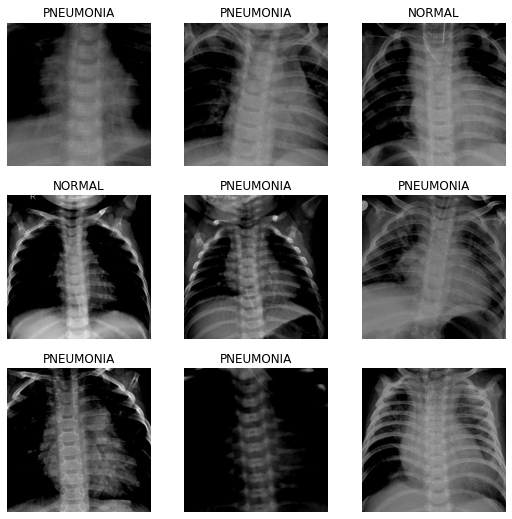

In [9]:
plt.figure(figsize=(9,9))
for i in range(1,10):
    data=next(iter(train_loader))
    rand_ind=torch.randint(0,batch_size-1,size=(1,)).item()
    label=data[1][rand_ind]
    image=data[0][rand_ind].permute(1,2,0)
    plt.title(train_data.classes[label.item()])
    plt.subplot(3,3,i)
    plt.axis(False)
    plt.imshow(image)
    

### Optimizer and Loss and Logdir

In [10]:
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

In [11]:
log_dir = "./"+model_name+"feature_extractor_tensorboard"
writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)
    

### Testing model

In [12]:
model.eval()
with torch.inference_mode():
    x,y=next(iter(train_loader))
    x=x.to(device)
    y=y.to(device)
    logits=model(x)
    print(logits)
    print(loss_fn(logits.squeeze(),y))
    print(accuracy_fn(logits,y))

tensor([[-0.0364,  0.0274],
        [-0.1850,  0.0531],
        [-0.0279, -0.0196],
        [ 0.6262,  0.1385],
        [-0.3871, -0.1623],
        [ 0.0075, -0.0185],
        [-0.0213,  0.1515],
        [ 0.0202,  0.3688],
        [-0.0411,  0.1075],
        [ 0.0626,  0.0693],
        [-0.2751,  0.4333],
        [-0.0758, -0.1129],
        [-0.2667, -0.2460],
        [-0.1648,  0.4302],
        [-0.0505,  0.0968],
        [-0.2139,  0.0648],
        [ 0.0014,  0.1890],
        [-0.2748, -0.0466],
        [ 0.1892, -0.1337],
        [-0.1777,  0.0739],
        [ 0.4264,  0.0687],
        [-0.2216,  0.3013],
        [-0.1246, -0.0038],
        [ 0.1349,  0.0785]], device='cuda:0')
tensor(0.6683, device='cuda:0')
0.5416666666666666


### Training Loop

In [13]:
epochs=10

train_accuracy=[]
test_accuracy=[]
train_loss=[]
test_loss=[]

for i in tqdm(range(epochs)):
    print("Training:")
    model.train()
    
    #Defining accuracy and loss for train and test data
    temp_train_accuracy=[]
    temp_test_accuracy=[]
    temp_train_loss=[]
    temp_test_loss=[]

    net_train_accuracy=0
    net_test_accuracy=0
    net_train_loss=0
    net_test_loss=0
    
    with tqdm(total=len(train_loader)) as pbar:
        for x,y in train_loader:
                x=x.to(device)
                y=y.to(device)
    
                #Calculating model output
                logits=model(x)
    
                #Reseting any old gradient values
                optimizer.zero_grad()
                loss=loss_fn(logits.squeeze(),y)

            
                #Track of metrics        
                accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                temp_train_accuracy.append(accuracy_train)
                temp_train_loss.append(loss.item())
    
                #Back Propogation
                loss.backward()
            
                #Update Parameters
                optimizer.step()
            
                #Progress Bar Update
                pbar.update(1)
        pbar.close()
    #Tensorboard & Metrics for the dataset
    net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
    net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    train_accuracy.append(net_train_accuracy)
    train_loss.append(net_train_loss)
    writer.add_scalar("Train Accuracy",net_train_accuracy,i)
    writer.add_scalar("Train Loss",net_train_loss,i)

    #Evaluation
    print("Testing:")
    model.eval()

    with tqdm(total=len(test_loader)) as pbar2:
        for x,y in test_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(logits.squeeze().type(torch.float32),y)

                #Track of metrics
                accuracy_test=accuracy_fn(logits,y)
                temp_test_accuracy.append(accuracy_test)
                temp_test_loss.append(loss.item())

                #Progress Bar Update
                pbar2.update(1)
        pbar2.close()

    #Tensorboard & Metrics for the dataset
    net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
    net_test_loss=sum(temp_test_loss)/len(temp_test_loss)
    test_accuracy.append(net_test_accuracy)
    test_loss.append(net_test_loss)
    writer.add_scalar("Test Accuracy",net_test_accuracy,i)
    writer.add_scalar("Test Loss",net_test_loss,i)

    '''
    #Saving the model
    try:
        os.makedirs(f"./{model_name}_feature_extractor/")
    except Exception as e:
        pass
    torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
    '''
    
    print(f"Epoch {i+1}:\nTrain Accuracy: {net_train_accuracy}  Train Loss: {net_train_loss}  Test Accuracy: {net_test_accuracy}  Test Loss: {net_test_loss}")
    print("\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1:
Train Accuracy: 0.9193989071038253  Train Loss: 0.20749416782220448  Test Accuracy: 0.9595628415300549  Test Loss: 0.11891003377491334


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2:
Train Accuracy: 0.9715391621129329  Train Loss: 0.09115037644699298  Test Accuracy: 0.9609289617486337  Test Loss: 0.10070010524273651


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3:
Train Accuracy: 0.9710837887067397  Train Loss: 0.07709236444108306  Test Accuracy: 0.9651639344262295  Test Loss: 0.11636064759623564


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4:
Train Accuracy: 0.9776867030965394  Train Loss: 0.05918197757786342  Test Accuracy: 0.9698087431693991  Test Loss: 0.12719420370546583


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5:
Train Accuracy: 0.9822404371584698  Train Loss: 0.05139392058016278  Test Accuracy: 0.9657103825136614  Test Loss: 0.11878068485587347


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6:
Train Accuracy: 0.9854280510018218  Train Loss: 0.04896514488390012  Test Accuracy: 0.9621584699453554  Test Loss: 0.13612613772026827


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7:
Train Accuracy: 0.9487704918032793  Train Loss: 0.15571828268161755  Test Accuracy: 0.9420765027322406  Test Loss: 0.15012930303079183


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8:
Train Accuracy: 0.9508196721311478  Train Loss: 0.13598734722727188  Test Accuracy: 0.9532786885245904  Test Loss: 0.13594608892091228


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9:
Train Accuracy: 0.9740437158469947  Train Loss: 0.0661002475748607  Test Accuracy: 0.9532786885245903  Test Loss: 0.12331116244532779


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10:
Train Accuracy: 0.9776867030965394  Train Loss: 0.06125133521840564  Test Accuracy: 0.9678961748633881  Test Loss: 0.11416823717338018


